sources:

https://blog.keras.io/building-autoencoders-in-keras.html
https://github.com/PyTorchLightning/pytorch-lightning/blob/master/pl_examples/basic_examples/autoencoder.py

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
# %matplotlib notebook

## Data

First, let's have a look on the data

In [3]:
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

In [4]:
_DATASETS_PATH = 'data' # path to directory where data are to be stored

torchvision library allows to easily download some of the most popular datasets

In [5]:
# transform = torchvision.transforms.Compose(
#     [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
#       torchvision.transforms.Normalize((0.1307), (0.3081))])

In [6]:
mnist_train = MNIST(_DATASETS_PATH, train=True, download=True, transform=transforms.ToTensor());
mnist_test = MNIST(_DATASETS_PATH, train=False, download=True, transform=transforms.ToTensor());

Let's see what the data look like

In [7]:
img, target = mnist_train[0]
print(f'image type: {type(img)}, image shape: {img.shape}, target: {target}, target class name: {mnist_train.classes[target]}')

image type: <class 'torch.Tensor'>, image shape: torch.Size([1, 28, 28]), target: 5, target class name: 5 - five


The image is a torch.Tensor object, and the target an integer. Notice that the image has 3 dimensions: single channel and 28 height x 28 width \
In order to visualize it correctly, we need to reduce it to 2 dimensional  height x width tensor

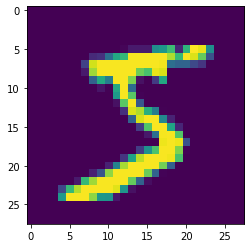

In [8]:
plt.imshow(img[0])

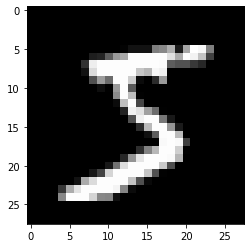

In [9]:
plt.imshow(img.repeat((3,1,1)).permute(1,2,0))

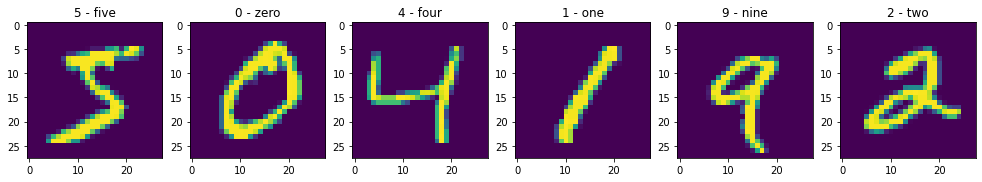

In [10]:
num_images = 6
fig, axs = plt.subplots(ncols=num_images, figsize=(17,5))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[i].imshow(img[0])
    axs[i].set_title(f'{mnist_train.classes[target]}')
    
    

## Model

In [11]:
import torch
from torch import nn

## fully-conected model

In [12]:
class FCAutoencoder(nn.Module):
    def __init__(self, io_size, hidden_dim, latent_dim):
        super(FCAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(io_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, io_size),
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [13]:
hidden_dim = 64
latent_dim = 8

In [14]:
fc_autoencoder = FCAutoencoder(28*28, hidden_dim, latent_dim)

Let's seet if this works

In [15]:
input_batch = img.unsqueeze(0)
print('input shape:', input_batch.shape)
with torch.no_grad(): # tell pytorch to not store the values for bakckward (gradient computing) pass
    print('output shape:', fc_autoencoder(input_batch).shape)
    z = fc_autoencoder.encoder(input_batch)
    print('representation shape:', z.shape)

input shape: torch.Size([1, 1, 28, 28])
output shape: torch.Size([1, 784])
representation shape: torch.Size([1, 8])


Reminder: pytorch models by default operate on batches. The first index points to imge position in the batch

### Task \#1
Since we are iterested in the latent space representation, it will be useful to have a function which encode image. Your task is to code the function, which returns image representation. Remember to disable gradient. 

In [16]:
def encode_image(img, autoencoder):
    with torch.no_grad():
        z = autoencoder.encoder(img.unsqueeze(0))[0]
    return z

In [17]:
@torch.no_grad()
def encode_image(img, autoencoder):
    z = autoencoder.encoder(img.unsqueeze(0))[0]
    return z

Test your solution:

In [18]:
fc_autoencoder.to('cpu');

In [19]:
encode_image(img, fc_autoencoder).shape

torch.Size([8])

### Task \#2
Reconstruct image: encode + decode

In [20]:
def reconstruct_image(img, autoencoder):
    with torch.no_grad():
        z = autoencoder(img.unsqueeze(0))[0].view(img.shape)
    return z

Is the output shape correct?

In [21]:
reconstruct_image(img, fc_autoencoder).shape

torch.Size([1, 28, 28])

If so, let's look at the image

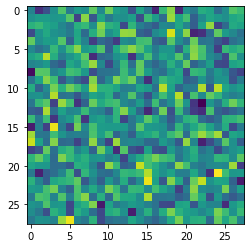

In [22]:
plt.imshow(reconstruct_image(img, fc_autoencoder)[0])

## Training

In [23]:
batch_size = 128

In [24]:
from torch.utils.data import DataLoader

In [25]:
mnist_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

Closer look on dataloaders

In [26]:
x, y = next(iter(mnist_train_dataloader))
print(f'x shape: {x.shape}')
print(f'target shape: {y.shape}')
print(f'target: {y}')

x shape: torch.Size([128, 1, 28, 28])
target shape: torch.Size([128])
target: tensor([3, 0, 8, 7, 1, 8, 1, 8, 8, 9, 9, 7, 5, 8, 8, 9, 3, 4, 4, 1, 1, 6, 3, 9,
        1, 4, 0, 7, 2, 2, 6, 1, 8, 5, 9, 0, 3, 0, 2, 3, 6, 2, 3, 0, 5, 1, 5, 8,
        5, 4, 6, 4, 3, 2, 1, 0, 0, 6, 7, 9, 0, 6, 5, 7, 2, 8, 8, 7, 6, 4, 0, 1,
        7, 3, 6, 5, 3, 3, 5, 7, 3, 9, 8, 1, 1, 9, 6, 1, 3, 2, 4, 3, 0, 9, 7, 7,
        3, 3, 6, 5, 9, 8, 9, 1, 0, 0, 9, 1, 1, 4, 3, 3, 9, 4, 9, 0, 9, 3, 6, 6,
        0, 3, 9, 3, 0, 9, 3, 5])


In [27]:
def training_step(autoencoder, batch, criterion, device='cpu'):
    x, y = batch
    x = x.to(device)
    x_hat = autoencoder(x) 
    loss = criterion(x_hat, x.view((len(x), -1)))
    return loss

In [28]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
fc_autoencoder.to(device);
optimizer = torch.optim.AdamW(fc_autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [29]:
import tqdm

In [30]:
x, y = next(iter(mnist_train_dataloader))

In [32]:
x_hat = fc_autoencoder(x.to(device))

In [35]:
criterion(x.view(len(x), -1).to(device), x_hat)

tensor(0.2328, grad_fn=<MseLossBackward>)

In [36]:
num_epochs = 20

history = []
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm.notebook.tqdm_notebook(mnist_train_dataloader, desc=f'epoch {i_epoch}'):
        # clear gradient from previous step
        optimizer.zero_grad()
        loss = training_step(fc_autoencoder, batch, criterion, device)
        epoch_losses.append(loss.item())
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
    epoch_loss = np.mean(epoch_losses)
    print(f'loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

epoch 0:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0582


epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0326


epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0290


epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0276


epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0267


epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0261


epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0255


epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0251


epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0247


epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0244


epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0242


epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0240


epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0238


epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0236


epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0234


epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0232


epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0231


epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0229


epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0228


epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

loss: 0.0227


Text(0.5, 1.0, 'train loss')

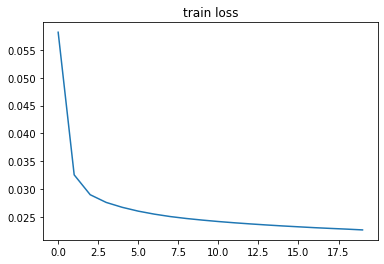

In [37]:
plt.plot([entry['loss'] for entry in history])
plt.title('train loss')

In [38]:
fc_autoencoder.to('cpu');

In [39]:
img, target = mnist_test[0]
reconstruction = reconstruct_image(img, fc_autoencoder)

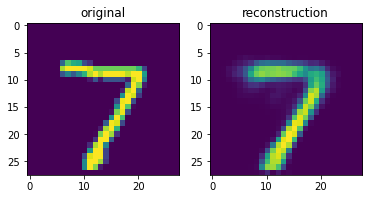

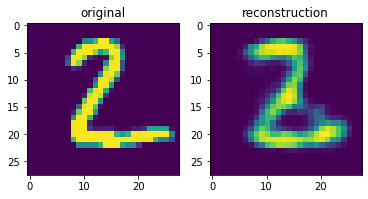

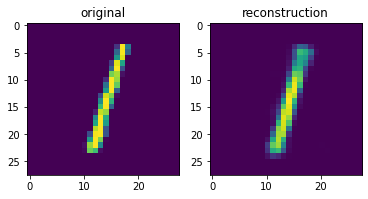

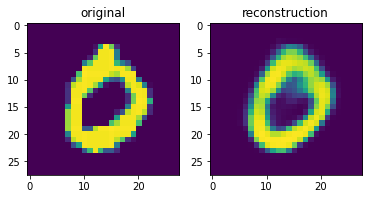

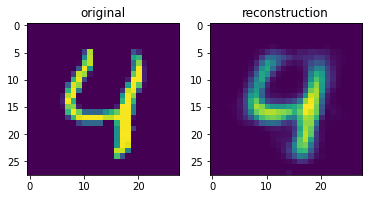

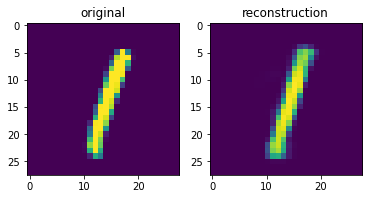

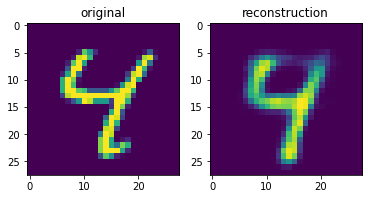

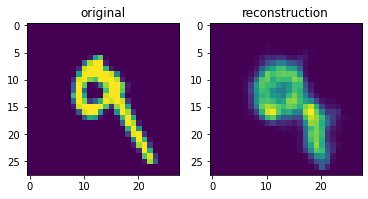

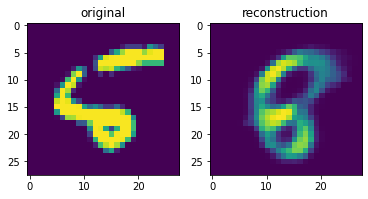

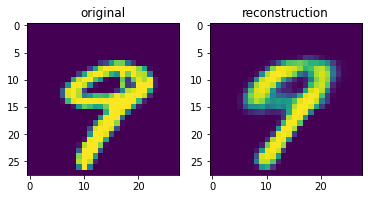

In [40]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, fc_autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0])
    axs[0].set_title('original')
    axs[1].imshow(reconstruction[0])
    axs[1].set_title('reconstruction')

# Latent space distribution

In [41]:
import numpy as np

In [42]:
encode_image(mnist_test[0][0], fc_autoencoder).shape

torch.Size([8])

In [43]:
representations = np.array([encode_image(x[0], fc_autoencoder).numpy() for x in mnist_test]) #
labels = np.array([x[1] for x in mnist_test])

In [44]:
labels

array([7, 2, 1, ..., 4, 5, 6])

In [45]:
representations.shape

(10000, 8)

In [46]:
import pandas as pd

In [47]:
%matplotlib qt

In [48]:
pd.plotting.scatter_matrix(pd.DataFrame(representations), alpha=0.2);

C:\Users\M\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


In [49]:
from sklearn.decomposition import PCA
pca_embedding = PCA(n_components=2).fit_transform(representations)

In [50]:
plt.figure()
plt.title('PCA embedding')
for i, label in enumerate(mnist_test.classes):
    X_cat = pca_embedding[labels==i]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=f'{label}', c=f'C{i}', alpha=0.2)
plt.legend()

In [51]:
from sklearn.manifold import TSNE

In [52]:
tsne_embedded = TSNE(n_components=2).fit_transform(representations)

In [53]:
plt.figure()
plt.title('TSNE embedding')
for i, label in enumerate(mnist_test.classes):
    X_cat = tsne_embedded[labels==i]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=f'{label}', c=f'C{i}', alpha=0.2)
plt.legend()

In [54]:
%matplotlib inline

## Reconstruction errors and outliers
Autoencores are often used to detect outliers. Rare events tend to be poorly reconstructed by the model

In [55]:
reconstruction_errors= []

def distance_function(x, x_hat):
    return torch.mean((x-x_hat)**2, dim=1)

fc_autoencoder.to(device);
for x, y in mnist_test_dataloader:
    x = x.to(device)
    x_hat = fc_autoencoder(x.to(device))
    errors = distance_function(x.view(len(x), -1), x_hat)
    reconstruction_errors.extend([el.item() for el in errors])

(array([1529., 2800., 2821., 1695.,  716.,  285.,  105.,   26.,   17.,
           6.]),
 array([0.00181575, 0.0105173 , 0.01921885, 0.0279204 , 0.03662194,
        0.04532349, 0.05402504, 0.06272659, 0.07142814, 0.08012969,
        0.08883124]),
 <BarContainer object of 10 artists>)

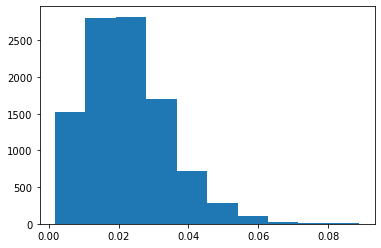

In [56]:
plt.hist(reconstruction_errors)

Some of the worst cases..

In [57]:
fc_autoencoder.cpu();

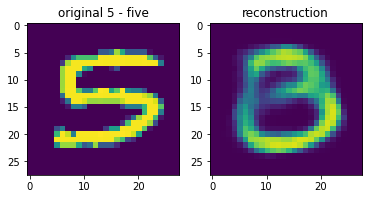

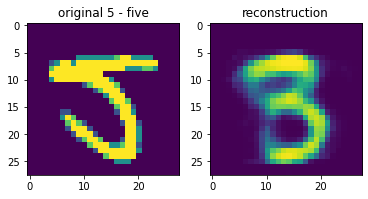

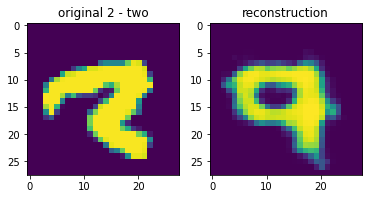

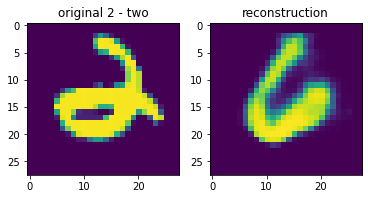

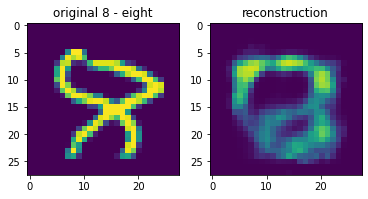

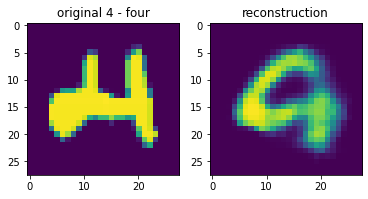

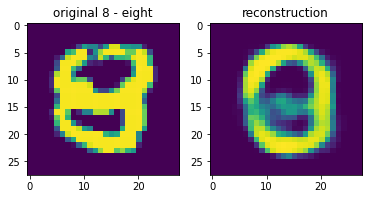

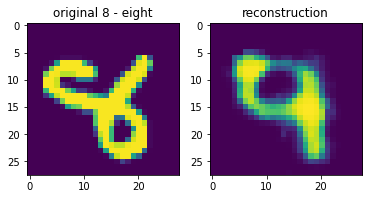

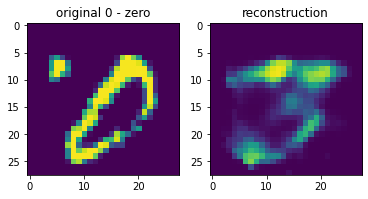

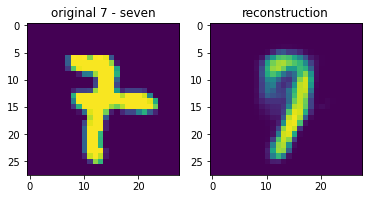

In [58]:
for idx in np.argsort(reconstruction_errors)[-10:]:
    img, target = mnist_test[idx]
    reconstruction = reconstruct_image(img, fc_autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title(f'original {mnist_test.classes[target]}')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

### your task \# 3
display the best and the worst reconstruction of each digit

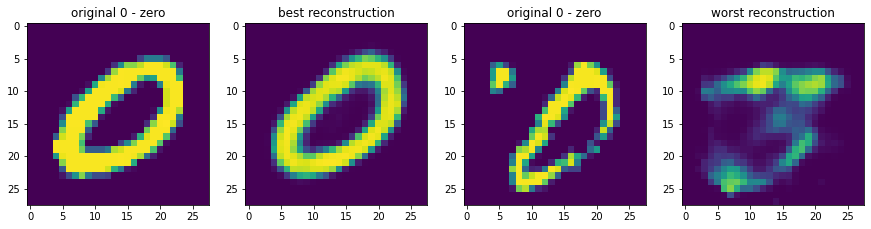

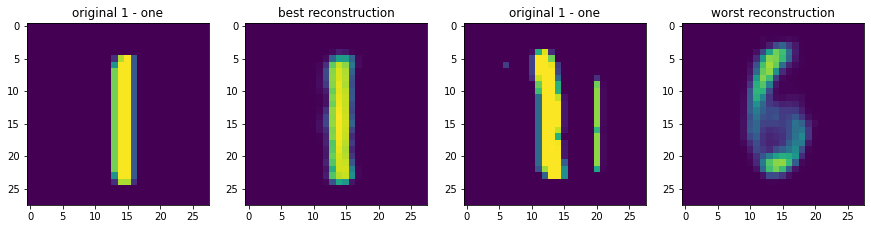

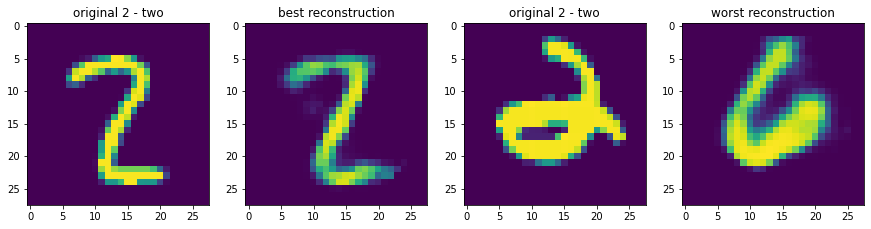

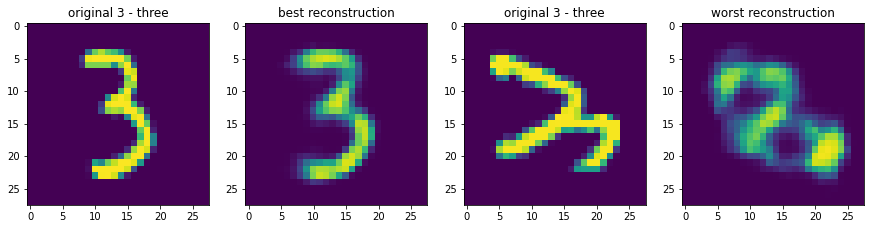

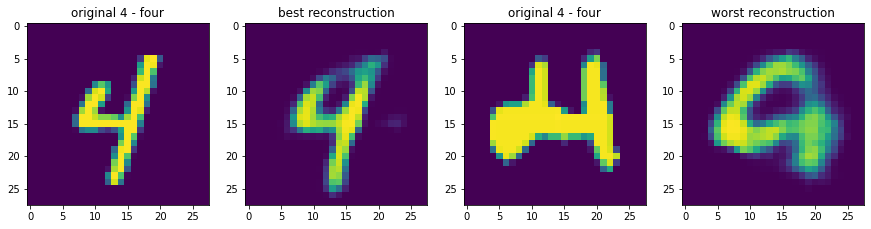

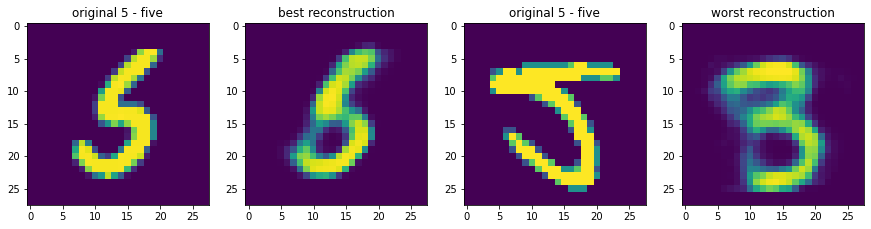

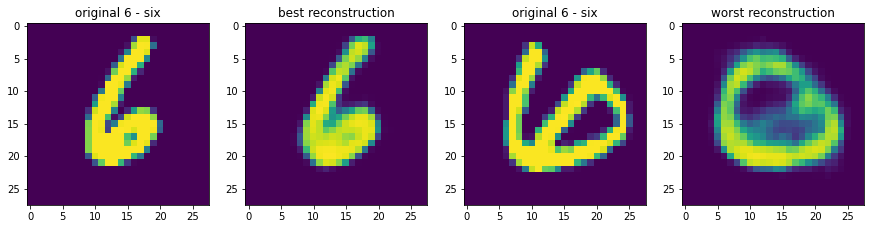

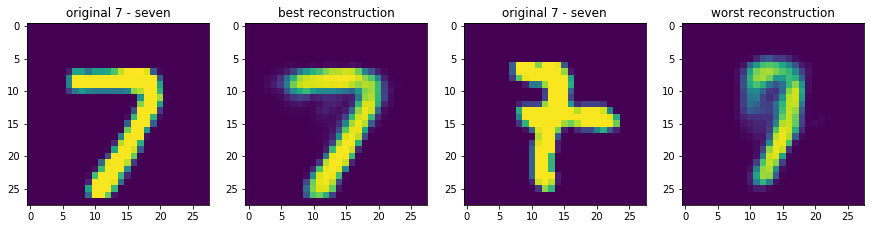

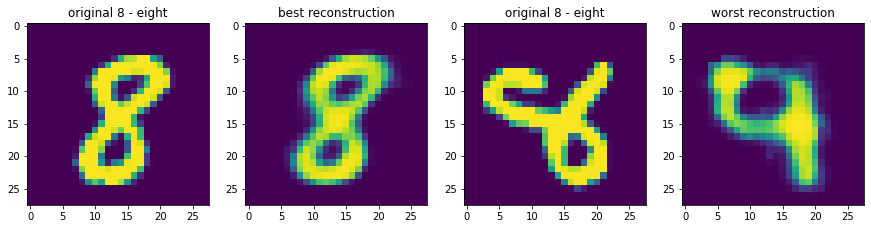

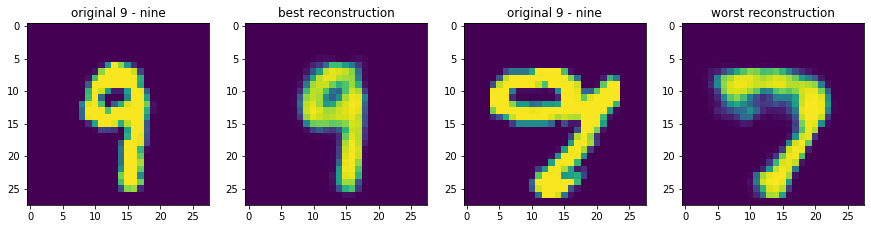

In [59]:
reconstruction_errors = np.array(reconstruction_errors)
for digit in range(10):
    digit_indices = np.where(labels==digit)[0]
    idx_best = digit_indices[np.argmin(reconstruction_errors[digit_indices])]
    idx_worst = digit_indices[np.argmax(reconstruction_errors[digit_indices])]
    fig, axs = plt.subplots(ncols=4, figsize=(15, 6))
    
    img, target = mnist_test[idx_best]
    reconstruction = reconstruct_image(img, fc_autoencoder)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title(f'original {mnist_test.classes[target]}')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('best reconstruction')
    
    img, target = mnist_test[idx_worst]
    reconstruction = reconstruct_image(img, fc_autoencoder)
    axs[2].imshow(img[0], vmin=0, vmax=1)
    axs[2].set_title(f'original {mnist_test.classes[target]}')
    axs[3].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[3].set_title('worst reconstruction')

## Anomalies

In [60]:
from torchvision.datasets import EMNIST

EMNIST is dataset similar to MNIST, but except of digist it contains also letters

In [61]:
emnist_test = EMNIST(_DATASETS_PATH, split='letters', train=False, download=True, transform=transforms.ToTensor());

In [62]:
emnist_test.classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

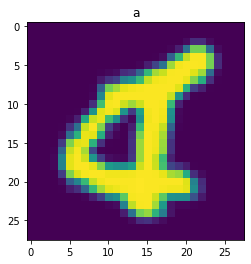

In [63]:
img, target = emnist_test[5]
plt.imshow(img[0])
plt.title(emnist_test.classes[target]);

### Your task

let's assume you have some unwanted letters from "EMNIST letters" mixed with "MNIST test" dataset. Can you distinguish them from numbers? Tip: we likely would not obtain 100% accuracy. Check what precision/recall can you get

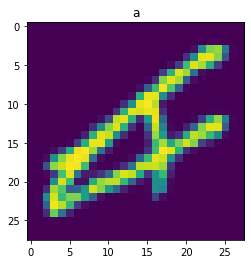

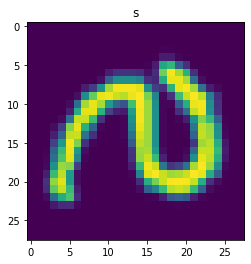

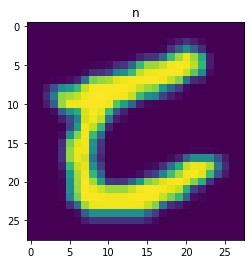

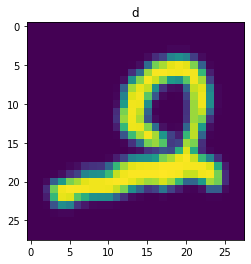

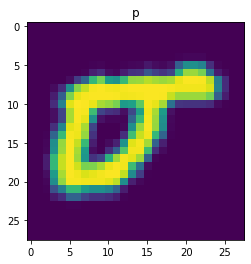

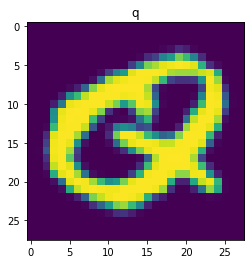

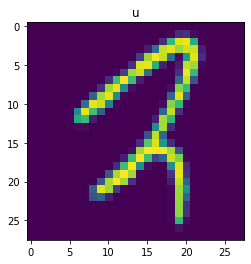

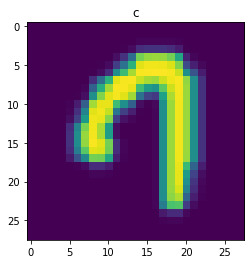

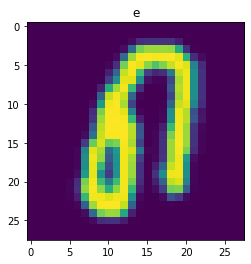

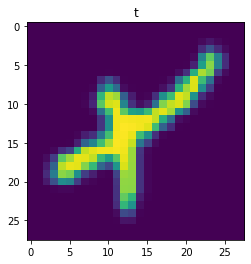

In [64]:
#prepare fake dataset
n_letters = len(mnist_test)
letter_indices = np.random.choice(np.arange(len(emnist_test)), n_letters, replace=False)
for idx in letter_indices[:10]:
    img, target = emnist_test[idx]
    plt.figure()
    plt.title(emnist_test.classes[target])
    plt.imshow(img[0], vmin=0, vmax=1)

In [65]:
#your code here


Answer

In [66]:
letters_reconstruction_errors= []
for idx in letter_indices:
    img, _ = emnist_test[idx]
    reconstruction = reconstruct_image(img, fc_autoencoder)
    letters_reconstruction_errors.append(np.mean((reconstruction.numpy() - img.numpy())**2))    

(array([ 220.,  969., 2489., 2752., 2038., 1003.,  361.,  125.,   36.,
           7.]),
 array([0.00353417, 0.02203842, 0.04054267, 0.05904691, 0.07755116,
        0.0960554 , 0.11455965, 0.1330639 , 0.15156814, 0.17007239,
        0.18857664], dtype=float32),
 <BarContainer object of 10 artists>)

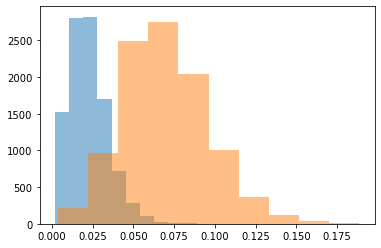

In [67]:
plt.hist(reconstruction_errors, alpha=0.5)
plt.hist(letters_reconstruction_errors, alpha=0.5)

In [68]:
import pandas as pd

In [69]:
df = pd.DataFrame([{'class': 0, 'error': x} for x in reconstruction_errors] + [{'class': 1, 'error': x} for x in letters_reconstruction_errors])

In [70]:
from sklearn.metrics import precision_recall_curve

In [71]:
precision, recall, thresholds = precision_recall_curve(df['class'], df['error'])

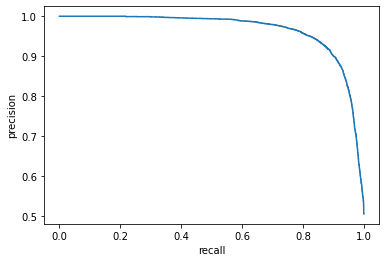

In [72]:
plt.plot(recall, precision)
plt.xlabel('recall');
plt.ylabel('precision');

In [73]:
from sklearn.metrics import roc_auc_score

In [74]:
roc_auc_score(df['class'], df['error'])

0.95935938

## prototypes

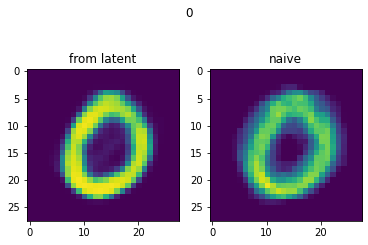

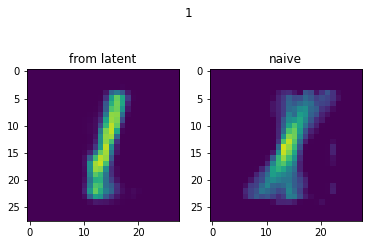

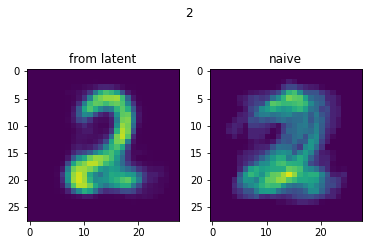

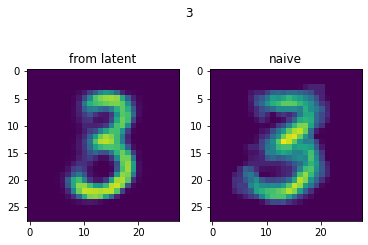

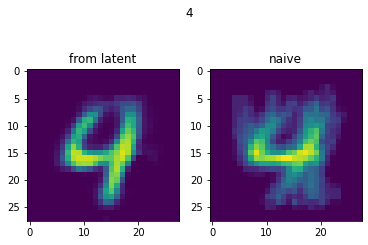

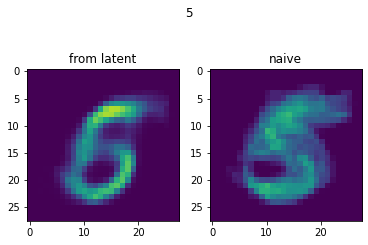

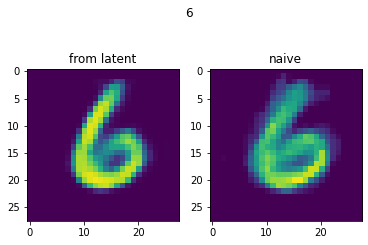

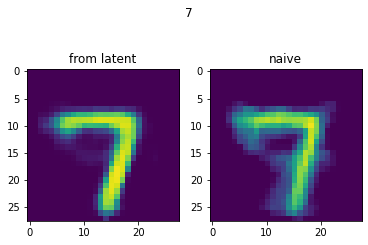

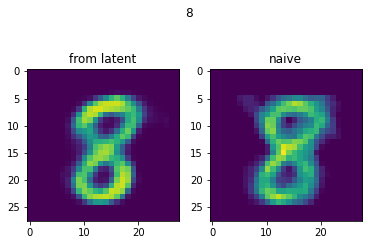

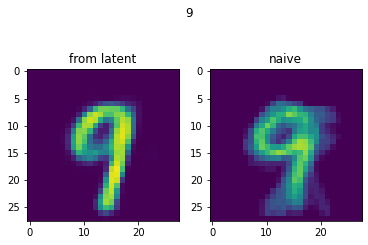

In [75]:
k_for_prototype = 10
for digit in range(10):
    #pick k examples of a class ("support")
    digit_indices = np.where(labels==digit)[0]
    support_indices = np.random.choice(digit_indices, k_for_prototype, replace=False)
    # calculate representations and construct prototype
    support_images = [mnist_test[idx][0] for idx in support_indices]
    support = np.array([encode_image(img, fc_autoencoder).numpy() for img in support_images])
    prototype = torch.Tensor(np.mean(support, axis=0))
    with torch.no_grad():
        new_img = fc_autoencoder.decoder(prototype.unsqueeze(0))[0]
    naive_new_img = np.mean(np.array([x.numpy() for x in support_images]), axis=0)
    
    fig, axs = plt.subplots(ncols=2)
    fig.suptitle(str(digit))

    axs[0].imshow(new_img.view(28,28), vmin=0, vmax=1)
    axs[0].set_title('from latent')
    
    axs[1].imshow(naive_new_img[0], vmin=0, vmax=1)
    axs[1].set_title('naive')
    

  

Latent space representations are much better to average the images.

Similar approach are used to few-shot learning
https://www.cs.toronto.edu/~zemel/documents/prototypical_networks_nips_2017.pdf

# Convolutional autoencoder

In [76]:
class ConvAutoencoder(nn.Module):
    """zrodlo ??"""
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode_image(self, x):
        with torch.no_grad():
            return self.encoder(x.unsqueeze(0))[0].view(1,-1)
        

In [77]:
conv_ae = ConvAutoencoder()

In [78]:
conv_ae(img.unsqueeze(0)).shape

torch.Size([1, 1, 28, 28])

In [79]:
def training_step_conv(autoencoder, batch, criterion, device='cpu'):
    x, y = batch
    x = x.to(device)
    x_hat = autoencoder(x) 
    loss = criterion(x_hat, x)
    return loss

In [80]:
optimizer = torch.optim.AdamW(conv_ae.parameters(), lr=1e-3)
conv_ae.to(device);

In [81]:
device

'cpu'

In [82]:
num_epochs = 20

for i_epoch in range(num_epochs):
#     print(f'epoch {i_epoch}')
    for batch in tqdm.notebook.tqdm_notebook(mnist_train_dataloader, desc=f'epoch {i_epoch}'):
        # clear gradient from previous step
        optimizer.zero_grad()
        loss = training_step_conv(conv_ae, batch, criterion, device)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()

epoch 0:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

In [83]:
conv_ae.encoder.cpu()(img.unsqueeze(0))[0].shape

torch.Size([8, 2, 2])

# Latent space distribution

In [84]:
representations = np.array([conv_ae.encode_image(x[0]).numpy()[0] for x in mnist_test]) #

labels = np.array([x[1] for x in mnist_test])

In [85]:
X_embedded = TSNE(n_components=2).fit_transform(representations)

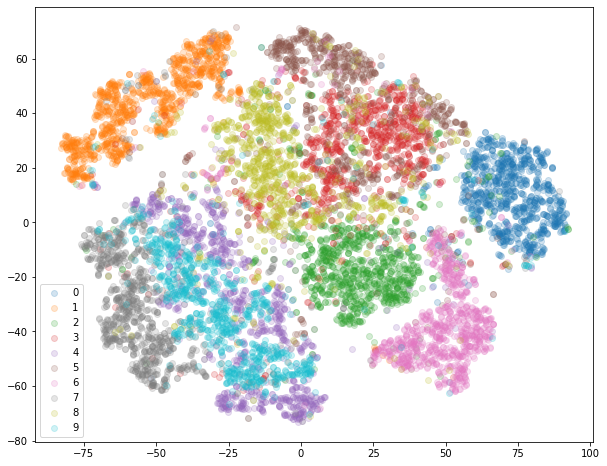

In [89]:
plt.figure(figsize=(10,8))
for i, label in enumerate(np.unique(labels)):
    X_cat = X_embedded[labels==label]
    plt.scatter(X_cat[:,0], X_cat[:,1], label=f'{i}', c=f'C{i}', alpha=0.2)
plt.legend()

## Reconstruction errors

In [87]:
conv_reconstruction_errors= []
conv_ae.to(device);
for x, y in mnist_test_dataloader:
    x = x.to(device)
    x_hat = conv_ae(x.to(device))
    errors = distance_function(x.view(len(x), -1), x_hat.view(len(x), -1))
    conv_reconstruction_errors.extend([el.item() for el in errors]) 

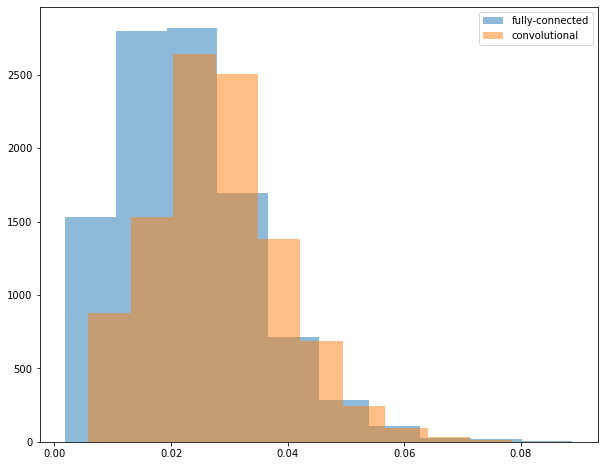

In [91]:
plt.figure(figsize=(10,8))
plt.hist(reconstruction_errors, alpha=0.5, label='fully-connected')
plt.hist(conv_reconstruction_errors, alpha=0.5, label='convolutional')
plt.legend()